### 1. Load Data and Modules


In [14]:
working_directory = '/home/duytruong/Working/Test/Zalora/Offline'

import os
os.chdir(working_directory)

import pandas as pd 
import numpy as np

training = pd.read_csv('data/raw/trainingData.csv', 
                       header = None, 
                       names = ['session_id', 'start_time', 'end_time', 'product_views'])
training_labels = pd.read_csv('data/raw/trainingLabels.csv', header = None, names = ['gender'])
training['is_female'] = training_labels['gender'] == 'female'
training.describe()

,session_id,start_time,end_time,product_views,is_female
count,15000,15000,15000,15000,15000
unique,15000,14938,14928,13087,2
top,u22018,2014-12-05 22:04:13,2014-12-09 09:13:51,A00002/B00002/C00007/D00266/,True
freq,1,2,2,39,11703


### 2. Some basic features

It seemed that we only had 4 columns from the trainingData, the first column was session_id which was unusable. However, the 3 other columns could be used to predict gender. 

First let's generate some new columns from product_views. I wanted to see how many products were viewed per sessions. I also wanted to know which cate & product were firsly viewed, since it might better reflect the interest of user. At the same time, I would like to know which cate_x and products were viewed during a| whole session. 

In [15]:
from src.model.featuring import ProductFeatures

product_feature_gen = ProductFeatures()
training_product_features = product_feature_gen.fit_transform(training)
training_product_features.head()


,product_views,view_counts,first_cate_0_view,first_cate_1_view,first_cate_2_view,first_product_view,cate_0,cate_1,cate_2,product
0,"[[A00001, B00001, C00001, D00001]]",1,A00001,B00001,C00001,A00001,[A00001],[B00001],[C00001],[D00001]
1,"[[A00002, B00002, C00002, D24897]]",1,A00002,B00002,C00002,A00002,[A00002],[B00002],[C00002],[D24897]
2,"[[A00002, B00002, C00002, D00002], [A00002, B0...",12,A00002,B00002,C00002,A00002,"[A00002, A00002, A00002, A00002, A00002, A0000...","[B00002, B00002, B00002, B00002, B00002, B0000...","[C00002, C00003, C00007, C00002, C00003, C0000...","[D00002, D00003, D00007, D00009, D00010, D0001..."
3,"[[A00002, B00006, C00015, D00030]]",1,A00002,B00006,C00015,A00002,[A00002],[B00006],[C00015],[D00030]
4,"[[A00002, B00002, C00003, D00033], [A00002, B0...",3,A00002,B00002,C00003,A00002,"[A00002, A00002, A00002]","[B00002, B00002, B00002]","[C00003, C00007, C00007]","[D00033, D00035, D00038]"


There were some features that could be generated from start_time and end_time columns. Using start_time, I knew which week_day it was, was it a working day or aweekend day, was it a dunday, was a session a starting days of a month (first 5 days of a month), or a ending days of a month (last 5 days of a month). I also knew which hour it occured and how many seconds it was last.


In [16]:
from src.model.featuring import DateFeatures

date_feature_gen = DateFeatures()
training_date_features = date_feature_gen.fit_transform(training)
training_date_features.head()

,week_day,is_working_day,is_weekend_day,is_sunday,is_start_of_month,is_end_of_month,hour,session_duration,log_session_duration
0,4,True,False,False,False,False,0,6,1.791759
1,4,True,False,False,False,False,14,1,0.000000
2,4,True,False,False,False,False,0,839,6.732211
3,4,True,False,False,False,False,0,2,0.693147
4,4,True,False,False,False,False,0,197,5.283204


Here I tried to combine 2 dataset and did some visualization to see if is there anything that I could use to train my model

In [17]:
simple_features_df = pd.concat([training_date_features, training_product_features], axis=1)
simple_features_df['is_female'] = training_labels['gender'] == 'female'
simple_features_df.head()

,week_day,is_working_day,is_weekend_day,is_sunday,is_start_of_month,is_end_of_month,hour,session_duration,log_session_duration,product_views,view_counts,first_cate_0_view,first_cate_1_view,first_cate_2_view,first_product_view,cate_0,cate_1,cate_2,product,is_female
0,4,True,False,False,False,False,0,6,1.791759,"[[A00001, B00001, C00001, D00001]]",1,A00001,B00001,C00001,A00001,[A00001],[B00001],[C00001],[D00001],True
1,4,True,False,False,False,False,14,1,0.000000,"[[A00002, B00002, C00002, D24897]]",1,A00002,B00002,C00002,A00002,[A00002],[B00002],[C00002],[D24897],True
2,4,True,False,False,False,False,0,839,6.732211,"[[A00002, B00002, C00002, D00002], [A00002, B0...",12,A00002,B00002,C00002,A00002,"[A00002, A00002, A00002, A00002, A00002, A0000...","[B00002, B00002, B00002, B00002, B00002, B0000...","[C00002, C00003, C00007, C00002, C00003, C0000...","[D00002, D00003, D00007, D00009, D00010, D0001...",True
3,4,True,False,False,False,False,0,2,0.693147,"[[A00002, B00006, C00015, D00030]]",1,A00002,B00006,C00015,A00002,[A00002],[B00006],[C00015],[D00030],True
4,4,True,False,False,False,False,0,197,5.283204,"[[A00002, B00002, C00003, D00033], [A00002, B0...",3,A00002,B00002,C00003,A00002,"[A00002, A00002, A00002]","[B00002, B00002, B00002]","[C00003, C00007, C00007]","[D00033, D00035, D00038]",True


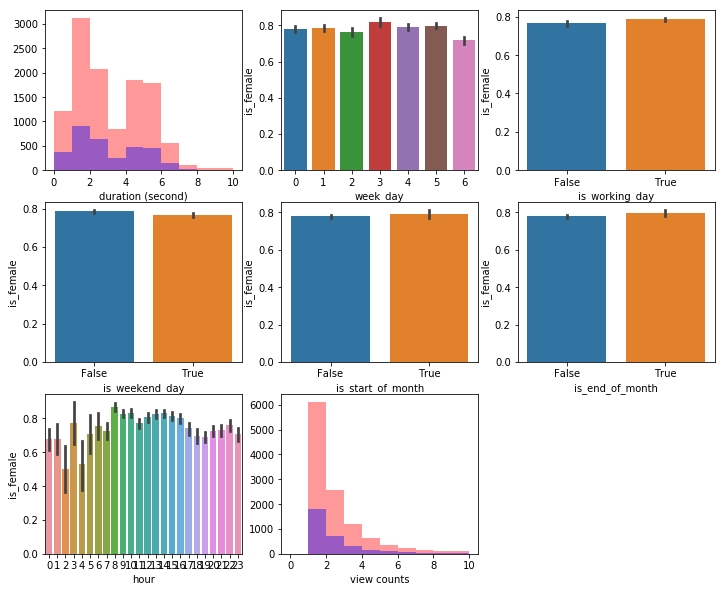

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


#simple_features_df['log_session_duration'] = np.log(simple_features_df['session_duration'])

female_color = 'red'
male_color = 'blue'

plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(simple_features_df['log_session_duration'][simple_features_df.is_female].values, bins=range(0, 11, 1), kde=False, color=female_color)
sns.distplot(simple_features_df['log_session_duration'][~simple_features_df.is_female].values, bins=range(0, 11, 1), kde=False, color=male_color,
            axlabel='duration (second)')
plt.subplot(332)
sns.barplot('week_day', 'is_female', data=simple_features_df)
plt.subplot(333)
sns.barplot('is_working_day', 'is_female', data=simple_features_df)
plt.subplot(334)
sns.barplot('is_weekend_day', 'is_female', data=simple_features_df)
plt.subplot(335)
sns.barplot('is_start_of_month', 'is_female', data=simple_features_df)
plt.subplot(336)
sns.barplot('is_end_of_month', 'is_female', data=simple_features_df)
plt.subplot(337)
sns.barplot('hour', 'is_female', data=simple_features_df)
plt.subplot(338)
sns.distplot(simple_features_df['view_counts'][simple_features_df.is_female].values, bins=range(0, 11, 1), kde=False, color=female_color)
sns.distplot(simple_features_df['view_counts'][~simple_features_df.is_female].values, bins=range(0, 11, 1), kde=False, color=male_color,
            axlabel='view counts')

The graphs showed that even though there were some difference bettween male and female, it was not significant. Let's try to generate a heatmap to see it more clear

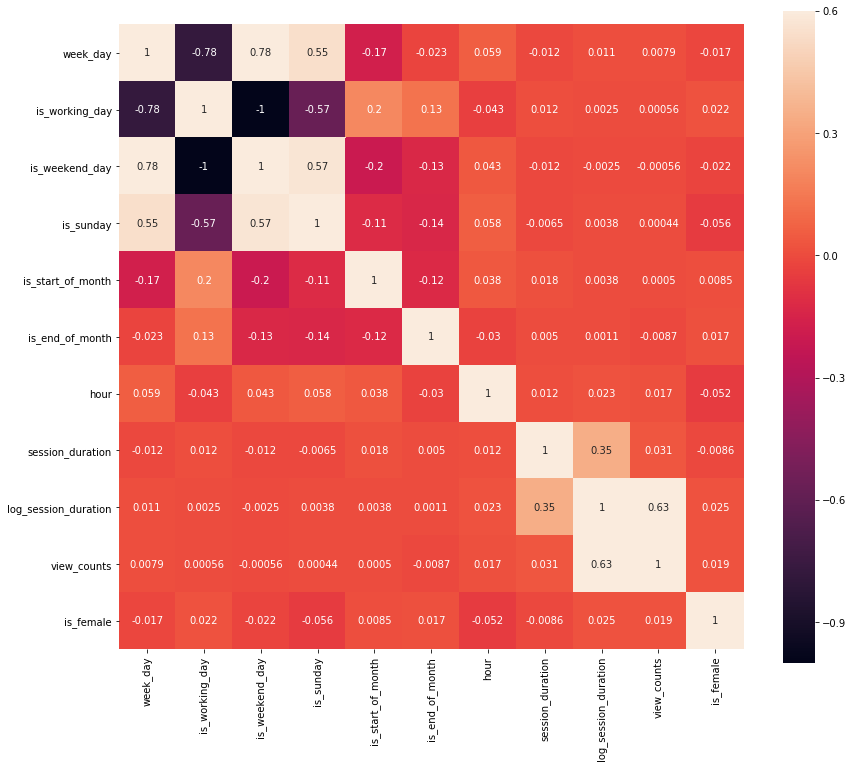

In [19]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(simple_features_df.corr(), vmax=0.6, square=True, annot=True)


/home/duytruong/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


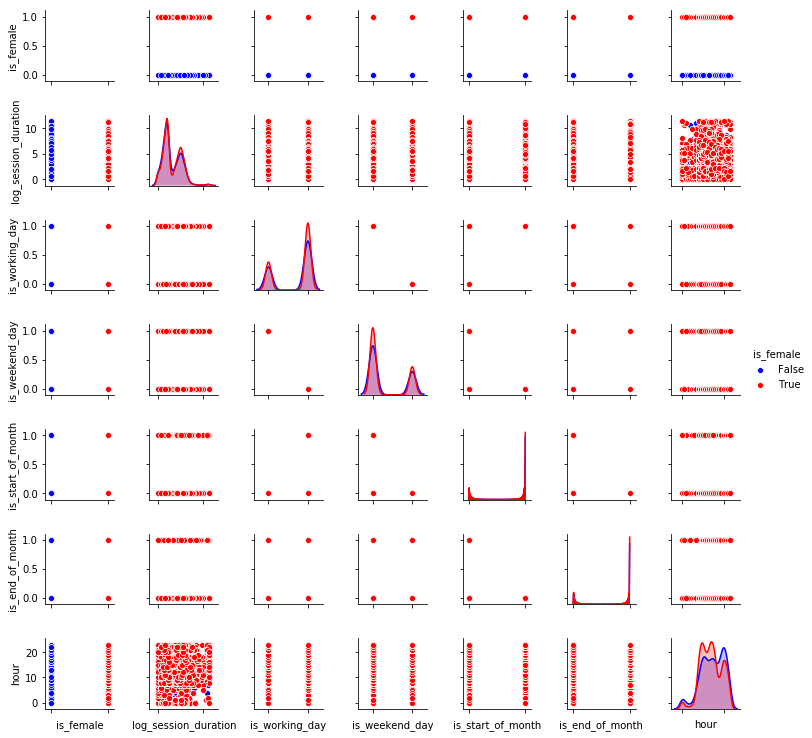

In [28]:
cols = ['is_female','log_session_duration','is_working_day','is_weekend_day','is_start_of_month','is_end_of_month', 'hour']
g = sns.pairplot(data=simple_features_df, vars=cols, size=1.5,
                 hue='is_female', palette=[male_color, female_color])
g.set(xticklabels=[])

## 3.Some advanced features 

I would like to create some advanced features like: **average_log_session_duration_per_item, gender_ratio by hour, week_day, cate_x, product, first_cate_x_view, first_product_view.**

In [21]:
from src.model.featuring import ItemDateTimeFeatures

item_datetime_features_gen = ItemDateTimeFeatures()
item_datetime_features_df = item_datetime_features_gen.fit_transform(simple_features_df)
item_datetime_features_df.head()

,week_day,is_working_day,is_weekend_day,is_sunday,is_start_of_month,is_end_of_month,hour,session_duration,log_session_duration,product_views,...,first_cate_0_view,first_cate_1_view,first_cate_2_view,first_product_view,cate_0,cate_1,cate_2,product,is_female,log_view_duration
0,4,True,False,False,False,False,0,6,1.791759,"[[A00001, B00001, C00001, D00001]]",...,A00001,B00001,C00001,A00001,[A00001],[B00001],[C00001],[D00001],True,1.791759
1,4,True,False,False,False,False,14,1,0.000000,"[[A00002, B00002, C00002, D24897]]",...,A00002,B00002,C00002,A00002,[A00002],[B00002],[C00002],[D24897],True,0.000000
2,4,True,False,False,False,False,0,839,6.732211,"[[A00002, B00002, C00002, D00002], [A00002, B0...",...,A00002,B00002,C00002,A00002,"[A00002, A00002, A00002, A00002, A00002, A0000...","[B00002, B00002, B00002, B00002, B00002, B0000...","[C00002, C00003, C00007, C00002, C00003, C0000...","[D00002, D00003, D00007, D00009, D00010, D0001...",True,4.247304
3,4,True,False,False,False,False,0,2,0.693147,"[[A00002, B00006, C00015, D00030]]",...,A00002,B00006,C00015,A00002,[A00002],[B00006],[C00015],[D00030],True,0.693147
4,4,True,False,False,False,False,0,197,5.283204,"[[A00002, B00002, C00003, D00033], [A00002, B0...",...,A00002,B00002,C00003,A00002,"[A00002, A00002, A00002]","[B00002, B00002, B00002]","[C00003, C00007, C00007]","[D00033, D00035, D00038]",True,4.184591


In [31]:
from src.model.featuring import y_ratio_by_group

female_ratio_by_day_gen = y_ratio_by_group('week_day', tocsr=False)
female_ratio_by_day_df = female_ratio_by_day_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_hour_gen = y_ratio_by_group('hour', tocsr=False)
female_ratio_by_hour_df = female_ratio_by_hour_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_first_cate0_gen = y_ratio_by_group('first_cate_0_view', tocsr=False)
female_ratio_by_first_cate0_df = female_ratio_by_first_cate0_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_first_cate1_gen = y_ratio_by_group('first_cate_1_view', tocsr=False)
female_ratio_by_first_cate1_df = female_ratio_by_first_cate1_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_first_cate2_gen = y_ratio_by_group('first_cate_2_view', tocsr=False)
female_ratio_by_first_cate2_df = female_ratio_by_first_cate2_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_first_product_gen = y_ratio_by_group('first_product_view', tocsr=False)
female_ratio_by_first_product_df = female_ratio_by_first_product_gen.fit_transform(simple_features_df, simple_features_df.is_female)


In [32]:
from src.model.featuring import y_ratio_by_list

female_ratio_by_cate_0_gen = y_ratio_by_list('cate_0', tocsr=False)
female_ratio_by_cate_0_df = female_ratio_by_cate_0_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_cate_1_gen = y_ratio_by_list('cate_1', tocsr=False)
female_ratio_by_cate_1_df = female_ratio_by_cate_1_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_cate_2_gen = y_ratio_by_list('cate_2', tocsr=False)
female_ratio_by_cate_2_df = female_ratio_by_cate_2_gen.fit_transform(simple_features_df, simple_features_df.is_female)

female_ratio_by_product_gen = y_ratio_by_list('product', tocsr=False)
female_ratio_by_product_df = female_ratio_by_product_gen.fit_transform(simple_features_df, simple_features_df.is_female)


In [33]:
simple_features_df['log_view_duration'] = item_datetime_features_df.iloc[:, 0]
simple_features_df['female_ratio_by_day'] = female_ratio_by_day_df
simple_features_df['female_ratio_by_hour'] = female_ratio_by_hour_df
simple_features_df['female_ratio_by_cate_0'] = female_ratio_by_cate_0_df
simple_features_df['female_ratio_by_cate_1'] = female_ratio_by_cate_1_df
simple_features_df['female_ratio_by_cate_2'] = female_ratio_by_cate_2_df
simple_features_df['female_ratio_by_product'] = female_ratio_by_product_df
simple_features_df['female_ratio_by_first_cate_0'] = female_ratio_by_first_cate0_df
simple_features_df['female_ratio_by_first_cate_1'] = female_ratio_by_first_cate1_df
simple_features_df['female_ratio_by_first_cate_2'] = female_ratio_by_first_cate2_df
simple_features_df['female_ratio_by_first_product'] = female_ratio_by_first_product_df
advanced_features = ['log_view_duration', 'female_ratio_by_day', 'female_ratio_by_hour'
                     , 'female_ratio_by_cate_0','female_ratio_by_cate_1','female_ratio_by_cate_2','female_ratio_by_product'
                     , 'female_ratio_by_first_cate_0','female_ratio_by_first_cate_1'
                     , 'female_ratio_by_first_cate_2','female_ratio_by_first_cate_2'
                    ]

The heatmap indicated that some of the advanced features (ratio by cate_x & product) could be used in our model, since the correlationship were high.

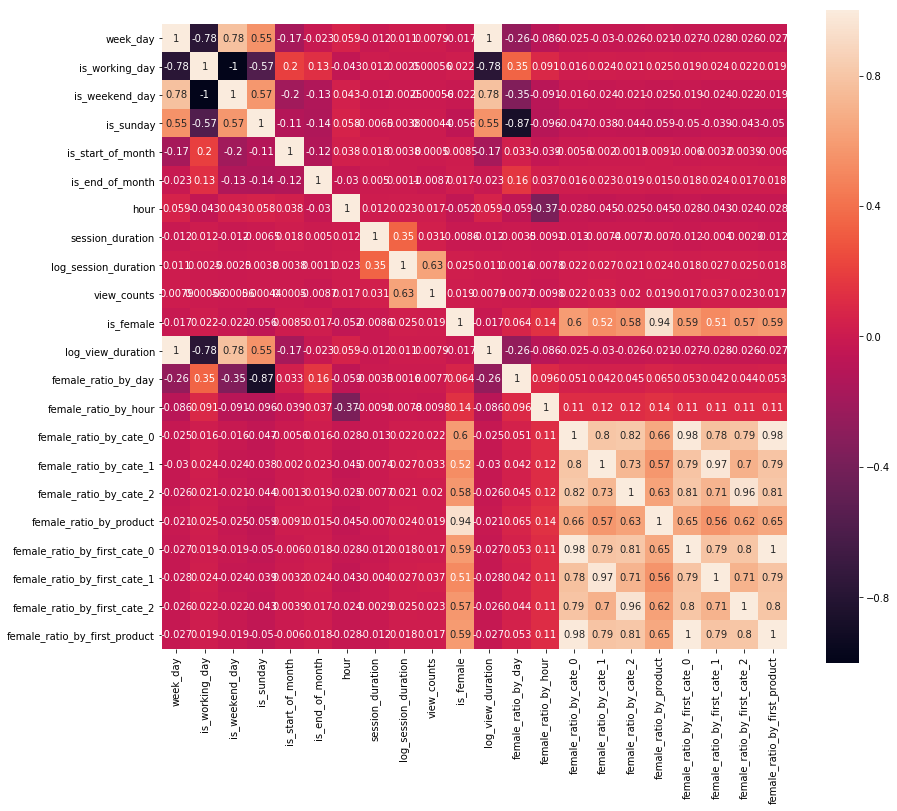

In [34]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(simple_features_df.corr(), vmax=1, square=True, annot=True)


The pair plot also revealed that the classes could be identified using those features.

/home/duytruong/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


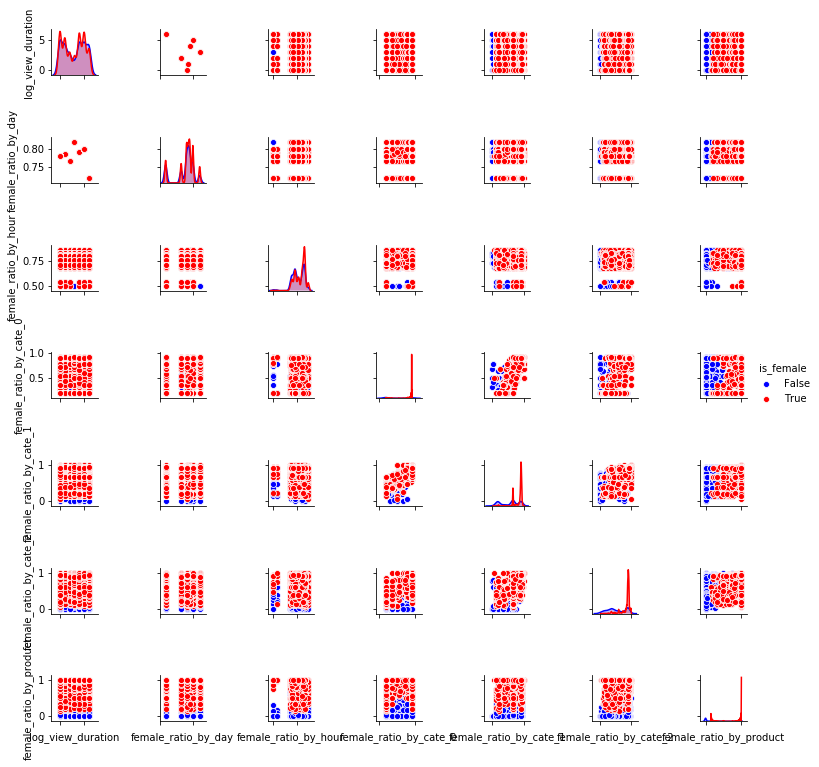

In [36]:

g = sns.pairplot(data=simple_features_df, vars=advanced_features[:7], size=1.5,
                 hue='is_female', palette=[male_color, female_color])
g.set(xticklabels=[])

Before putting those features into model training, I would like to create some more advanced features:

1/ I would like to create an interaction matrix, where the rows were session and the columns were interacted cate_x & product. However, the number of newly created features would be 2057 (11 cate_0 + 60 cate_1 + 186 cate_2+ 1800 product), which is too much. Hence, I used TruncatedSVD to reduce the number of features.

2/ I also used Matrix factorization technique to create latent vectors for each categories and products. Basing on the interaction, I could then create a new vector for each session.


### 4.Model selection

In [42]:
from src.model.pipeline_construction import full_pipeline
from sklearn.externals import joblib

In [45]:
cate_0 = joblib.load('data/processed/cate_0.jl')
cate_1 = joblib.load('data/processed/cate_1.jl')
cate_2 = joblib.load('data/processed/cate_2.jl')
products = joblib.load('data/processed/products.jl')

X = training
y = training['is_female']

# split dataset in to training and validation by 80:20 ratio
pl = full_pipeline(cate_0,cate_1, cate_2, products)

splitting_point = int(len(X)*0.8)

X_train = pl.fit_transform(training[:splitting_point], y[:splitting_point])
y_train = y[:splitting_point]

X_validation = pl.transform(training[splitting_point:])
y_validation = y[splitting_point:]


Here I normalize X and use SMOTE to create a balance dataset. SMOTE was chosen here, since it outperform ADASYN, upsampling and downsampling technique in our test

In [46]:
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_validation = normalize(X_validation)

from imblearn.over_sampling import RandomOverSampler, SMOTE,ADASYN
sampler = SMOTE(random_state=0)
X_rs, y_rs = sampler.fit_sample(X_train, y_train)


In [63]:
print("X train, y train shapes" )
print(X_train.shape, y_train.shape)
print("Female ratio: {}) \n".format(sum(y_train)/len(y_train)))

print("X train, y train shapes after upsampling with SMOTE" )
print(X_rs.shape, y_rs.shape)
print("New female ratio: {}) \n".format(sum(y_rs)/len(y_rs)))

X train, y train shapes
(12000, 204) (12000,)
Female ratio: 0.7798333333333334) 

X train, y train shapes after upsampling with SMOTE
(18716, 204) (18716,)
New female ratio: 0.5) 



First I tried to train a model using Random Forest and reviewed its performance

In [52]:
from sklearn.ensemble import RandomForestClassifier
from src.model.evaluation import print_score

rfc = RandomForestClassifier()
rfc.fit(X_rs, y_rs)
print_score(y_true = y_validation, y_pred = rfc.predict(X_validation))

/home/duytruong/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Evalute based on test set
 - custom score:  0.7513924380279626
 - f1 micro:  0.7773333333333333
 - f1 macro:  0.7144296801612418
 - accuracy score 0.7773333333333333
 - confusion matrix: 
[[ 462  193]
 [ 475 1870]]


Then, I tried to create a model using LogisticRegression to see if it could outperform RF

In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_rs, y_rs)
print_score(y_true = y_validation, y_pred = lr.predict(X_validation))

Evalute based on test set
 - custom score:  0.7793356011653836
 - f1 micro:  0.858
 - f1 macro:  0.7865126796099897
 - accuracy score 0.858
 - confusion matrix: 
[[ 419  236]
 [ 190 2155]]


It seemed that LogisticRegression performed much better than Random Forest (**0.779** comparing with **0.751**). I decided to fine tune RandomForest a bit to see if can perform better than default arguments

In [65]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [5, 10, 15, 20],
 'criterion': ['gini', 'entropy'],
 'n_estimators': [20, 40, 60, 80]}

from sklearn.model_selection import RandomizedSearchCV
rscv = RandomizedSearchCV(rfc, param_distributions = random_grid, n_iter=20, n_jobs= -1, cv = 5, verbose=5)
rscv.fit(X_rs, y_rs)
print_score(y_true = y_validation, y_pred = rscv.predict(X_validation))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.7min finished


Evalute based on test set
 - custom score:  0.7570500821953482
 - f1 micro:  0.818
 - f1 macro:  0.7451449966268275
 - accuracy score 0.818
 - confusion matrix: 
[[ 425  230]
 [ 316 2029]]


### 5.Conclusion

I ended up using LogisticRegression to build my model since it performed better than Random Forest. 

There are a few things that didn't show in this notebook:
 - I did try to find the length of feature vectors of categories and products so I could yield better perforamance. I also tried to find how many features at TruncatedSVD was good enough.
 - How I choose SMOTE instead of ADASYN, upsampling and downsampling to get a balanced training dataset.
 - I removed some ratio features since it reduced the performance of my models
 
Things to improve:
 - The MF idea seemed to be a good idea, but it takes time to find out the optimized length of those feature vectors. 
 - I might come up with some more advanced features

Other thoughts:
 - It depends on the real problem to judge if my approach is good enough for productionizing.